In [2]:
import seaborn as sns
import matplotlib.pyplot as plt

# 데이터셋 읽기

In [16]:
# 데이터파일 읽기
data = pd.read_csv('data/cs_data.csv',index_col=0)

- 제공되는 데이터셋의 컬럼명이 이해하기 어렵거나 사용하기 어렵다면 변경하도록 한다.
    - 컬럼명을 소문자로 변경함.

In [ ]:
data.columns = [col.lower() for col in data.columns]

# EDA

In [19]:
# data.describe().T

In [13]:
# 타겟(seriousdlqin2yrs) 분포 확인
data['seriousdlqin2yrs'].value_counts()

0    139974
1     10026
Name: seriousdlqin2yrs, dtype: int64

In [14]:
# 비율로 보기
data['seriousdlqin2yrs'].value_counts()/len(data['seriousdlqin2yrs'])

0    0.93316
1    0.06684
Name: seriousdlqin2yrs, dtype: float64

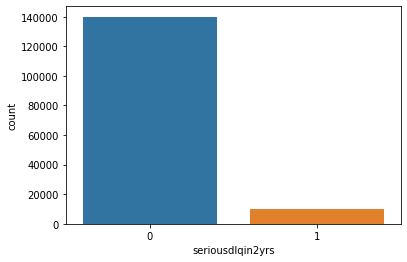

In [15]:
sns.countplot(data['seriousdlqin2yrs'])
plt.show()

# 결측치 처리

In [18]:
# data.isna().sum()

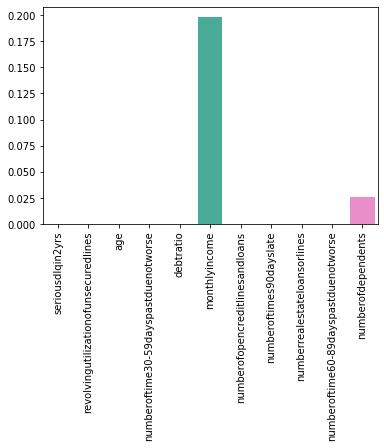

In [17]:
x_tick = data.columns
y = data.isna().mean()
sns.barplot(x_tick, y)
plt.xticks(rotation=90)
plt.show()

In [14]:
# 중앙값 확인 data.median()

In [15]:
# 평균값 확인 data.mean()

In [20]:
# 결측치 중위수로 처리
data = data.fillna((data.median()))

## 이상치 확인 및 처리

### IQR 기반 이상치 검출
- IQR : 3분위수-1분위수
- 이상치 기준 (rate는 일반적으로 1.5사용)
    - 1분위수 + IQR*rate 보다 작은수
    - 3분위 + IQR*rate 보다 큰수

In [21]:
def get_outlier(data, rate=1.5):
    q1 = np.quantile(data, q=0.25)
    q3 = np.quantile(data, q=0.75)
    IQR = q3 - q1
    return (data < q1 - IQR * rate) | (data > q3+IQR * rate)

In [22]:
#확인
print(data['revolvingutilizationofunsecuredlines'].describe())
print('1이상값 총개수',(data['revolvingutilizationofunsecuredlines'] > 1).sum())

count    150000.000000
mean          6.048438
std         249.755371
min           0.000000
25%           0.029867
50%           0.154181
75%           0.559046
max       50708.000000
Name: revolvingutilizationofunsecuredlines, dtype: float64
1이상값 총개수 3321


In [27]:
data.loc[data['revolvingutilizationofunsecuredlines']>1, 'revolvingutilizationofunsecuredlines'] = 1

In [28]:
#확인
print(data['revolvingutilizationofunsecuredlines'].describe())
print('1이상값 총개수',(data['revolvingutilizationofunsecuredlines'] > 1).sum())

count    150000.000000
mean          0.319196
std           0.349481
min           0.000000
25%           0.029867
50%           0.154181
75%           0.559046
max           1.000000
Name: revolvingutilizationofunsecuredlines, dtype: float64
1이상값 총개수 0


### age
- 대출자 나이
- 최소값이 0, 최대값 109
- 중위수로 변환 

In [24]:
data.loc[data['age']==0]

,seriousdlqin2yrs,revolvingutilizationofunsecuredlines,age,numberoftime30-59dayspastduenotworse,debtratio,monthlyincome,numberofopencreditlinesandloans,numberoftimes90dayslate,numberrealestateloansorlines,numberoftime60-89dayspastduenotworse,numberofdependents
65695,0,1.0,0,1,0.436927,6000.0,6,0,2,0,2.0


In [25]:
data.loc[data['age']==0, 'age'] = data['age'].median()

## monthlyincome
- 월간 소득
- 이상치를 이상치 아닌 값들의 최대 값으로 대체한다.

In [34]:
max_value_income = np.max(data.monthlyincome[~get_outlier(data['monthlyincome'])])
max_value_income

12626.0

In [35]:
# 정상값의 최대값으로 변환
data.loc[data['monthlyincome']>=max_value_income, 'monthlyincome'] = max_value_income

In [36]:
data['monthlyincome'].describe()

count    149731.000000
mean       5879.829501
std        3042.486899
min           0.000000
25%        3915.000000
50%        5400.000000
75%        7400.000000
max       12626.000000
Name: monthlyincome, dtype: float64

# 종속변수별 상관관계 확인


In [20]:
# plt.figure(figsize=(4,4)) #히트맵
# ax = sns.heatmap(data.corr(), annot=True, fmt='.2f', linewidths=0.5, cmap='YlGnBu')
# # print(ax.get_ylim())
# ax.set_ylim(11,0)
# plt.show()

In [17]:
# data.corr()

In [49]:
data.to_csv('data/data-v01.csv', index=False)

# 모델링

In [5]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, accuracy_score

In [6]:
y = data.seriousdlqin2yrs
X = data.drop('seriousdlqin2yrs', axis='columns')

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y)

In [8]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, stratify=y_train)

In [9]:
y_train.shape, y_val.shape, y_test.shape

((84223,), (28075,), (37433,))

## Scaling

In [16]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

## Base-line 모델 정의

In [11]:
knn = KNeighborsClassifier()

In [12]:
grb = GradientBoostingClassifier()

In [13]:
rf = RandomForestClassifier()

In [14]:
xgb = XGBClassifier()

In [24]:
xgb.fit(X_train_scaled, y_train)
grb.fit(X_train_scaled, y_train)
rf.fit(X_train_scaled, y_train)
knn.fit(X_train_scaled, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [25]:
base_line = [xgb, grb, rf, knn]
model_names = ['XGBoost', 'GradientBoosting', 'RandomForest', 'KNN']

In [26]:
for i in range(len(base_line)):
    
    pred_train = base_line[i].predict(X_train_scaled)
    pred_val = base_line[i].predict(X_val_scaled)
    
    pred_train_proba = base_line[i].predict_proba(X_train_scaled)
    pred_val_proba = base_line[i].predict_proba(X_val_scaled)
    
    acc_train = np.round(accuracy_score(y_train,pred_train),3)
    acc_val = np.round(accuracy_score(y_val, pred_val), 3)
    
    auc_train = np.round(roc_auc_score(y_train, pred_train_proba[:, 1]), 3)
    auc_val = np.round(roc_auc_score(y_val, pred_val_proba[:, 1]), 3)
    
    print(f'{model_names[i]}')
    print(f'train정확도:{acc_train}, validation정확도:{acc_val}\t train AUC:{auc_train}, validation AUC:{auc_val}')
    print('='*50)

XGBoost
train정확도:0.939, validation정확도:0.937	 train AUC:0.867, validation AUC:0.868
GradientBoosting
train정확도:0.94, validation정확도:0.938	 train AUC:0.866, validation AUC:0.868
RandomForest
train정확도:0.999, validation정확도:0.935	 train AUC:1.0, validation AUC:0.842
KNN
train정확도:0.945, validation정확도:0.932	 train AUC:0.952, validation AUC:0.74


# GridSearchCV를 이용해 best 모델 생성

In [30]:
#scale_pos_weight: XGBoost에서 불균형 모델일때 양성에 가중치를 주는 하이퍼파라미터. 보통 Negative개수/positive개수 를 기준으로 지정한다.
scale_pos_weight = (len(y)-y.sum())/y.sum()
param = {
    'learning_rate':[0.01,0.1,0.5,1,10],
    'n_estimators':[100,200,300,400,500],
    'max_depth':range(1,6),
    'subsample':[0.6,0.7,0.8,0.9,1],
    'scale_pos_weight':[scale_pos_weight+i for i in range(-3,4)]
}

14


In [28]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
r_search = RandomizedSearchCV(XGBClassifier(), param_distributions=param, n_iter=60, scoring='roc_auc', n_jobs=-1 )

In [1]:
# r_search.fit(X_train_scaled, y_train)

In [31]:
r_search.best_params_

{'subsample': 0.8,
 'scale_pos_weight': 17.15649357222391,
 'n_estimators': 200,
 'max_depth': 2,
 'learning_rate': 0.1}

In [ ]:
rs_df = pd.DataFrame(r_search.cv_results_)
rs_df.sort_values('rank_test_score').head()

In [33]:
best_model = r_search.best_estimator_

In [2]:
# best_model.fit(X_train_scaled, y_train)

In [35]:
pred_proba  = best_model.predict_proba(X_val_scaled)
AUC = roc_auc_score(y_val, pred_proba[:, 1])
AUC

0.8690849989980437

In [37]:
from sklearn.ensemble import VotingClassifier

In [38]:
param = {
    'n_estimators':[100,200,300],
    'max_depth':range(1,5)
}
r_search_gb = RandomizedSearchCV(GradientBoostingClassifier(), param_distributions=param, n_iter=60, cv=5, scoring='roc_auc', n_jobs=-1)
r_search_rf = RandomizedSearchCV(RandomForestClassifier(), param_distributions=param, n_iter=60, cv=5, scoring='roc_auc', n_jobs=-1)

In [39]:
estimators = [('xgb', best_model), ('gradient boost', r_search_gb), ('random forest', r_search_rf)]
vote = VotingClassifier(estimators=estimators, voting='soft', n_jobs=-1)

In [3]:
# vote.fit(X_train_scaled, y_train)

In [41]:
pred_proba  = vote.predict_proba(X_val_scaled)
AUC = roc_auc_score(y_val, pred_proba[:, 1])
AUC

0.8695801292766502

## Test Set 으로 검증
- XGBoostClassifier: 0.8690849989980437
- VotingClassifier : 0.8695801292766502

In [42]:
pred_proba_test = vote.predict_proba(X_test_scaled)
AUC_test = roc_auc_score(y_test, pred_proba_test[:, 1])
AUC_test

0.864383916091285